In [ ]:
import torch
from ConvNeXt.models.convnext import convnext_tiny

In [ ]:
model = convnext_tiny(pretrained=False, in_22k=False)

In [ ]:
state_dict = torch.load('./convnext_tiny_1k_224_ema.pth', map_location='cpu')['model']
model.load_state_dict(state_dict)
model = model.eval()

In [ ]:
dummpy_input = torch.rand(1,3,224,224)
torch.onnx.export(model, dummpy_input, 'convnext_tiny.onnx', input_names=['input'], output_names=['output'], opset_version=13, dynamic_axes={
    'input':{
        0:'batch_size'
    },
    'output': {
        0:'batch_size'
    }
})

In [ ]:
import netron

netron.stop()
netron.start('convnext_tiny.onnx')

# 去除gamma

In [ ]:
from ConvNeXt.models.convnext import Block

In [ ]:
from torch.fx import symbolic_trace, GraphModule, Graph

In [ ]:
import copy
import torch.nn as nn
from torch.fx.experimental.optimization import replace_node_module

In [ ]:
fx_model = symbolic_trace(copy.deepcopy(model))
graph = copy.deepcopy(fx_model.graph)
modules = dict(fx_model.named_modules())
state_dict = model.state_dict()

for node in graph.nodes:
    if 'get_attr' == node.op and 'gamma' in node.target:
        prev_node = node.prev
        prev_conv1x1_module = modules[prev_node.target]
        gamma = state_dict[node.target]
        # gamma(Ax+B)
        prev_conv1x1_module.weight.data.mul_(gamma.unsqueeze(-1))
        prev_conv1x1_module.bias.data.mul_(gamma)
        # 将mul_node删除替换为prev_node
#         print(node, node.format_node(), node.next)
        next_node = node.next
        next_node.replace_all_uses_with(prev_node)
        graph.erase_node(next_node)
        graph.erase_node(node)
        
#         print(prev_node.op, prev_node.target, prev_conv1x1_module, prev_conv1x1_module.bias.data.shape, gamma.size())
#         print(prev_node, node)
#     print(node, node.op, node.target)

In [ ]:
new_model = GraphModule(fx_model, graph)

In [ ]:
dummpy_input = torch.rand(1,3,224,224)
torch.onnx.export(new_model, dummpy_input, 'convnext_tiny_fuse_gamma.onnx', input_names=['input'], output_names=['output'], opset_version=13, dynamic_axes={
    'input':{
        0:'batch_size'
    },
    'output': {
        0:'batch_size'
    }
})

In [ ]:
# !netron convnext_tiny_fuse_gamma.onnx

In [ ]:
output1 = model(dummpy_input)
output2 = new_model(dummpy_input)

In [ ]:
torch.allclose(output1, output2, atol=1e-6)

# 聚合layernorm

In [ ]:
from ConvNeXt.models.convnext import LayerNorm

In [ ]:
from torch.autograd import Function
import torch.nn.functional as F
import torchvision

class LayerNormFunction(Function):
    
    @staticmethod
    def forward(ctx, x, normalized_shape, weight, bias, eps, data_format, method):
        return method(x)
        
    @staticmethod
    def symbolic(g, x, normalized_shape, weight, bias, eps, data_format, method):
        return g.op("LayerNorm", x, weight, bias, eps_f = eps, data_format_s = data_format) 

class ExportLayerNrom(LayerNorm):
        
    def forward(self, x):
        if torch.onnx.is_in_onnx_export():
            return LayerNormFunction.apply(x, self.normalized_shape, self.weight, self.bias, self.eps, self.data_format, super().forward)
        else:
            return super().forward(x)

In [ ]:
new_model = copy.deepcopy(model)
modules = dict(new_model.named_modules())

for name, module in new_model.named_modules():
    if 'norm' in name or isinstance(module, (nn.LayerNorm, LayerNorm)):
        weight = module.weight.data
        bias = module.bias.data
        names = name.split(".")
        parent_model = modules[".".join(names[:-1])]
        data_format = "channels_last"
        if hasattr(module, 'data_format'):
            data_format = module.data_format
        normalized_shape = bias.nelement()
        if hasattr(module, 'normalized_shape'):
            normalized_shape = module.normalized_shape[0]
        new_module = ExportLayerNrom(normalized_shape = normalized_shape, data_format=data_format, eps=module.eps).to(weight.device)
        new_module.weight.data.copy_(weight)
        new_module.bias.data.copy_(bias)
        setattr(parent_model, names[-1], new_module)

In [ ]:
new_model

In [ ]:
dummpy_input = torch.rand(1,3,224,224)
try:
    torch.onnx.export(new_model, dummpy_input, 'convnext_tiny_rep_layernorm.onnx', 
                  input_names=['input'], output_names=['output'], 
                  opset_version=13, dynamic_axes={
                    'input':{
                        0:'batch_size'
                    },
                    'output': {
                        0:'batch_size'
                  }},
    )
except torch.onnx.CheckerError:
    pass # ignore error

In [ ]:
import netron

In [ ]:
netron.stop()
netron.start('convnext_tiny_rep_layernorm.onnx')

# 融合gamma和更改layernorm

In [ ]:
from torch.autograd import Function
import torch.nn.functional as F
import torchvision

class LayerNormFunction(Function):
    
    @staticmethod
    def forward(ctx, x, normalized_shape, weight, bias, eps, data_format, method):
        return method(x)
        
    @staticmethod
    def symbolic(g, x, normalized_shape, weight, bias, eps, data_format, method):
        return g.op("LayerNorm", x, weight, bias, eps_f = eps, data_format_s = data_format) 

class ExportLayerNrom(LayerNorm):
        
    def forward(self, x):
        return LayerNormFunction.apply(x, self.normalized_shape, self.weight, self.bias, self.eps, self.data_format, super().forward)

In [ ]:
class MyTracer(torch.fx.Tracer):
    
    def is_leaf_module(self, m, module_qualified_name):
        return super().is_leaf_module(m, module_qualified_name) or isinstance(m, ExportLayerNrom)

In [ ]:
new_model = copy.deepcopy(model)
modules = dict(new_model.named_modules())

for name, module in new_model.named_modules():
    if 'norm' in name or isinstance(module, (nn.LayerNorm, LayerNorm)):
        weight = module.weight.data
        bias = module.bias.data
        names = name.split(".")
        parent_model = modules[".".join(names[:-1])]
        data_format = "channels_last"
        if hasattr(module, 'data_format'):
            data_format = module.data_format
        normalized_shape = bias.nelement()
        if hasattr(module, 'normalized_shape'):
            normalized_shape = module.normalized_shape[0]
        new_module = ExportLayerNrom(normalized_shape = normalized_shape, data_format=data_format, eps=module.eps).to(weight.device)
        new_module.weight.data.copy_(weight)
        new_module.bias.data.copy_(bias)
        setattr(parent_model, names[-1], new_module)

In [ ]:
graph = MyTracer().trace(copy.deepcopy(new_model))
modules = dict(new_model.named_modules())
state_dict = new_model.state_dict()

for node in graph.nodes:
    if 'get_attr' == node.op and 'gamma' in node.target:
        prev_node = node.prev
        prev_conv1x1_module = modules[prev_node.target]
        gamma = state_dict[node.target]
        # gamma(Ax+B)
        prev_conv1x1_module.weight.data.mul_(gamma.unsqueeze(-1))
        prev_conv1x1_module.bias.data.mul_(gamma)
        # 将mul_node删除替换为prev_node
#         print(node, node.format_node(), node.next)
        next_node = node.next
        next_node.replace_all_uses_with(prev_node)
        graph.erase_node(next_node)
        graph.erase_node(node)


In [ ]:
new_model = GraphModule(new_model, graph)

In [ ]:
dummpy_input = torch.rand(1,3,224,224)
try:
    torch.onnx.export(new_model, dummpy_input, 'convnext_tiny_fuse_gamma_rep_layernorm.onnx', 
                  input_names=['input'], output_names=['output'], 
                  opset_version=13, dynamic_axes={
                    'input':{
                        0:'batch_size'
                    },
                    'output': {
                        0:'batch_size'
                  }},
    )
except torch.onnx.CheckerError:
    pass # ignore error

In [ ]:
netron.stop()
netron.start('convnext_tiny_fuse_gamma_rep_layernorm.onnx')

## 通过直接修改onnx的方式来生成LayerNorm和融合gamma

In [ ]:
!python3 -m pip install onnx_graphsurgeon --index-url https://pypi.ngc.nvidia.com

In [ ]:
import onnx_graphsurgeon as gs
import onnx
import numpy as np

In [ ]:
onnx_graph = onnx.load('convnext_tiny.onnx')

In [ ]:
onnx_gs_graph = gs.import_onnx(onnx_graph)

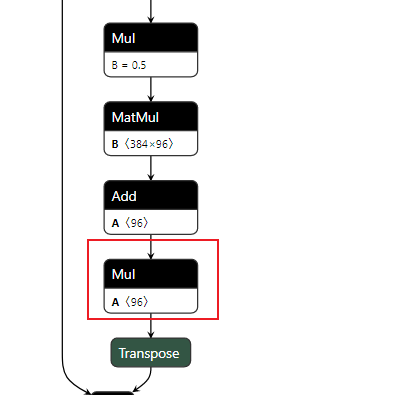

In [ ]:
for node in onnx_gs_graph.nodes:
    
    # 替换gamma
    if node.op != 'Mul':
        continue
    try:
        add_node = node.i(1)
    except:
        continue
    if add_node.op != 'Add':
        continue
    try:
        matmul_node = add_node.i(1)
    except:
        continue
    if matmul_node.op != 'MatMul':
        continue
    gamma = node.inputs[0].values
    weight = matmul_node.inputs[1].values
    bias = add_node.inputs[0].values
    print(weight.shape, bias.shape)
    new_bias = bias * gamma
    new_weight = weight * gamma[np.newaxis, ...]
#     print(gamma)
    add_node.inputs[0].values = new_bias
    matmul_node.inputs[1].values = new_weight
    # 去除gamma算子
    add_node.outputs[0] = node.outputs[0]
    node.outputs.clear()

In [ ]:
onnx_gs_graph = onnx_gs_graph.cleanup().toposort()

In [ ]:
# 合并LayeNorm
layernorm_idx = 0
for node in onnx_gs_graph.nodes:
    
    if node.op != 'ReduceMean':
        continue
    try:
        sub_nodes = list()
        for i in range(2):
            sub_nodes.append(node.o(i))
    except:
        pass
    if not sub_nodes or sub_nodes[0].op != 'Sub':
        continue
    
    div_node = None
    pow_node = None
    for sub_node in sub_nodes:
        if sub_node.op != 'Sub':
            continue
        try:
            for i in range(2):
                tmp_node = sub_node.o(i)
                if tmp_node.op == "Div":
                    div_node = tmp_node
                elif tmp_node.op == "Pow":
                    pow_node = tmp_node
        except:
            pass

    if div_node is None or pow_node is None:
        continue
    
    try:
        mul_node = div_node.o(0)
    except:
        continue
    if mul_node.op != 'Mul':
        continue
        
    try:
        add_node = mul_node.o(0)
    except:
        continue
    if add_node.op != 'Add':
        continue
    
    
    eps_node = pow_node.o(0).o(0)
    eps = eps_node.inputs[1].inputs[0].attrs['value'].values
    try:
        weight = mul_node.inputs[1].values
    except:
        weight = mul_node.inputs[0].values
        
    try:
        bias = add_node.inputs[0].values
    except:
        bias = add_node.inputs[1].values
    
    data_format = "channels_last" if int(node.attrs['axes'][0]) == -1 else "channels_first"
    if data_format != "channels_last":
        continue
    attrs = {
        'data_format':data_format,
        'eps':float(eps)
    }
    layernorm_idx += 1
    layernorm_name = 'LayerNorm-%d' % layernorm_idx
    print('layernorm_name', layernorm_name)
    weight_const = gs.Constant(name=layernorm_name+ "_weight", values=weight.reshape(-1))
    bias_const = gs.Constant(name=layernorm_name+ "_bias", values=bias.reshape(-1))
    new_layernorm_node = gs.Node('LayerNorm', name=layernorm_name, attrs=attrs, inputs = [node.inputs[0:1][0], weight_const, bias_const], outputs = add_node.outputs[0:1])
    
    add_node.outputs.clear()
    node.inputs.clear()
    sub_node.inputs.clear()
    onnx_gs_graph.nodes.append(new_layernorm_node)

In [ ]:
onnx_gs_graph = onnx_gs_graph.cleanup().toposort()

In [ ]:
onnx.save(gs.export_onnx(onnx_gs_graph), "convnext_tiny_rm_gamma_rep_layernorm_gs.onnx")

In [ ]:
netron.stop()
netron.start('convnext_tiny_rm_gamma_rep_layernorm_gs.onnx')